## **4. Import the necessary packages:**
numpy, io, glob, tqdm_notebook, confusion_matrix, random, itertools, matplotlib.pyplot, torch, torch.nn,  torch.nn.functional, torch.utils.data, torch.optim, torch.optim.lr_scheduler, torch.nn.init


In [1]:
# Importing 
from skimage import io
from glob import glob
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import confusion_matrix
import numpy as np
import random
import itertools
import matplotlib.pyplot as plt
import imagecodecs
# %matplotlib inline
# Torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torch.optim.lr_scheduler
import torch.nn.init
from torch.autograd import Variable
import os
from IPython.display import clear_output
import tifffile as tiff  

/home/avl1/anaconda3/envs/segmentation/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 ## **5. Initialization:**

In [2]:
# Parameters
IN_CHANNELS =  3                          # Number of input channels (e.g. RGB)
MAIN_FOLDER  =    "dataset/"   # Replace with your "/path/to/the/Images/folder/"
BATCH_SIZE =   10            # Number of samples in a mini-batch, example 10
LABELS = ["roads", "buildings", "low veg.", "trees", "cars", "clutter"] # Label names
N_CLASSES = len(LABELS)                   # Number of classes
weights = torch.ones(N_CLASSES)           # Weights for class balancing
DATA_FOLDER = MAIN_FOLDER + 'Images/Image_{}.tif'
LABELS_FOLDER = MAIN_FOLDER + 'Labels/Label_{}.tif'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

 ## **6. Functions you may need:**

In [5]:
# Let's define the standard ISPRS color palette
palette = {0 : (255, 255, 255), # Impervious surfaces (white)
           1 : (0, 0, 255),     # Buildings (blue)
           2 : (0, 255, 255),   # Low vegetation (cyan)
           3 : (0, 255, 0),     # Trees (green)
           4 : (255, 255, 0),   # Cars (yellow)
           5 : (255, 0, 0),     # Clutter (red)
           6 : (0, 0, 0)}       # Undefined (black)
invert_palette = {v: k for k, v in palette.items()}
def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """ '(From 0 to 6)'
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)
    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i
    return arr_2d
class Load_dataset(torch.utils.data.Dataset):
    def __init__(self, ids):
        super(Load_dataset, self).__init__()
        # List of files
        self.data_files = [DATA_FOLDER.format(id) for id in ids]
        self.label_files = [LABELS_FOLDER.format(id) for id in ids]
        # Sanity check : raise an error if some files do not exist
        for f in self.data_files + self.label_files:
            if not os.path.isfile(f):
                raise KeyError('{} is not a file !'.format(f))
    def __len__(self):
        return len(self.data_files) # the length of the used data
    
    def __getitem__(self, idx):
#         Pre-processing steps
        #     # Data is normalized in [0, 1]
        self.data = 1/255 * np.asarray(io.imread(self.data_files[idx]).transpose((2,0,1)), dtype='float32')
        self.label = np.asarray(convert_from_color(io.imread(self.label_files[idx])), dtype='int64')
        data_p, label_p = self.data,  self.label
        # Return the torch.Tensor values
        return (torch.from_numpy(data_p),
                torch.from_numpy(label_p))
def CrossEntropy2d(input, target, weight=weights.to(device), size_average=True):
    """ 2D version of the cross entropy loss """
    dim = input.dim()
    if dim == 2:
        return F.cross_entropy(input, target, weight, size_average)
    elif dim == 4:
        #print(f"input 1: {input.size()}")
        output = input.view(input.size(0), input.size(1), -1)
        #print(f"input 2: {output.size()}")
        output = torch.transpose(output, 1, 2).contiguous()
        #print(f"input 3 Transposed: {output.size()}")
        output = output.view(-1, output.size(2))
        #print(f"input 4: {output.size()}")
        #print(f"target: {target.size()}")
        target = target.view(-1)
        #print(f"Target last: {target.size()}")
        return F.cross_entropy(output, target, weight, size_average)
    else:
        raise ValueError('Expected 2 or 4 dimensions (got {})'.format(dim))
        
def metrics(predictions, gts, label_values=LABELS):
    predictions = torch.argmax(predictions,dim =1 )
    cm = confusion_matrix(
        gts,
        predictions,
        labels = 6) #range(len(label_values))
    print("Confusion matrix :")
    print(cm)
    print("---")
    # Compute global accuracy
    total = sum(sum(cm))
    accuracy = sum([cm[x][x] for x in range(len(cm))])
    accuracy *= 100 / float(total)
    print("{} pixels processed".format(total))
    print("Total accuracy : {}%".format(accuracy))
    return accuracy

# # **7. Selecting training and testing data**

In [6]:
train_ids =list(range(0, 2000))
test_ids =  list(range(2000,2400))
train_data = Load_dataset(train_ids)
test_data = Load_dataset(test_ids)

In [7]:
training_data = torch.utils.data.DataLoader(train_data,
                                             batch_size=BATCH_SIZE, shuffle=True,
                                             num_workers=8)
testing_data = torch.utils.data.DataLoader(test_data,
                                             batch_size=BATCH_SIZE, shuffle=True,
                                             num_workers=8)
                                            
                                            

## **8. Implement the Unet model**


In [8]:
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3,padding='same'),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3,padding='same'),
        nn.ReLU()
    )
def crop_tensor(input,target):
    diff =input.size()[2] - target.size()[2] # difference in width
    diff = diff // 2
    return(input[:,:,diff:input.size()[2]-diff,diff:input.size()[2]-diff])
class UNet(nn.Module):
    def __init__(self,IN_CHANNELS=3,OUT_CHANNELS=6):
        super().__init__() 
        self.encode_conv1 = conv_block(IN_CHANNELS, 64)
        self.encode_conv2 = conv_block(64, 128)
        self.encode_conv3 = conv_block(128, 256)
        self.encode_conv4 = conv_block(256, 512)
        self.encode_conv5 = conv_block(512, 1024)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv_transpose1 = nn.ConvTranspose2d(in_channels=1024,out_channels=512,kernel_size=2,stride=2)
        self.decode_conv1 = conv_block(1024, 512)
        self.conv_transpose2 = nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=2,stride=2)
        self.decode_conv2 = conv_block(512, 256)
        self.conv_transpose3 = nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=2,stride=2)
        self.decode_conv3 = conv_block(256, 128)
        self.conv_transpose4 = nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=2,stride=2)
        self.decode_conv4 = conv_block(128, 64)
        self.out = nn.Conv2d(in_channels=64,out_channels=OUT_CHANNELS,kernel_size=1)
     
    def forward(self, x):
        # Encoder
        x = x.to(device)
        x1 = self.encode_conv1(x).to(device)
        x2 = self.maxpool(x1).to(device)
        x3 = self.encode_conv2(x2).to(device)
        x4 = self.maxpool(x3).to(device)
        x5 = self.encode_conv3(x4).to(device)
        x6 = self.maxpool(x5)
        x7 = self.encode_conv4(x6)
        x8 = self.maxpool(x7)
        x9 = self.encode_conv5(x8)
        
        

        # Decoder x1,x3,x5,x7 will be used as input 
        p1d = (0, 1,0,1) # pad last dim by 1 on rigt and bottom side
        x10 = self.conv_transpose1(x9).to(device)
        x10 = F.pad(x10, p1d, "constant", 1).to(device)  # effectively zero padding
        x7_10 = torch.cat([x10,x7],dim=1).to(device)
        x11 = self.decode_conv1(x7_10).to(device)
        x12 = self.conv_transpose2(x11) .to(device) # x11
        x12 = F.pad(x12, p1d, "constant", 1).to(device)  # effectively zero padding
        x5_12 = torch.cat([x12,x5],dim=1).to(device)
        x13 = self.decode_conv2(x5_12).to(device)
        x14 = self.conv_transpose3(x13).to(device) 
        #x14 = F.pad(x14, p1d, "constant", 1)  # effectively zero padding
        x3_14 = torch.cat([x14,x3],dim=1).to(device)
        x15 = self.decode_conv3(x3_14).to(device)
        x16 = self.conv_transpose4(x15).to(device)
        #x16 = F.pad(x10, p1d, "constant", 1)  # effectively zero padding
        x1_16 = torch.cat([x16,x1],dim=1).to(device)
        x17 = self.decode_conv4(x1_16).to(device)
        out = self.out(x17).to(device)
        return out.squeeze(0)

In [9]:
model = UNet().to(device)

In [10]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

### Training U Net

In [26]:

def train(epochs = 5):
    running_loss = 0.
    epoch_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for epoch in range(epochs): 
        Num_batches = 0
        for i, data in enumerate(training_data):
            # Every data instance is an input + label pair
            inputs, labels = data
            # Zero your gradients for every batch!
            optimizer.zero_grad()

            # Make predictions for this batch
            outputs = model(inputs).to(device)
            
            # print("labels : ",type(labels))
            labels = labels.type(torch.LongTensor)
            labels = labels.unsqueeze(0).to(device)
            # print("Outputs : ",outputs.size())
            # print("Labels : ",labels.size())
            # Compute the loss and its gradients
            loss = CrossEntropy2d(outputs,labels).to(device)
            loss.backward()
            
            # Adjust learning weights
            optimizer.step()
            # if i%10 ==0:
            #     print(f"Loss {i} : {loss}")

            # Gather data and report
            # running_loss += loss.item()
            epoch_loss += loss.item()
            Num_batches+=1
            
            # if i % 10 == 9:
            #     last_loss = running_loss / 10 # loss per batch
            #     print('  batch {} loss: {}'.format(i + 1, last_loss))
            #     # tb_x = epoch_index * len(train_data) + i + 1
            #     # tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            #     running_loss = 0.
        epoch_loss = epoch_loss/Num_batches
        last_loss += epoch_loss
        print('  Epoch {} loss: {}'.format(epoch + 1, epoch_loss))
    return last_loss/epochs

In [30]:
Num_epochs = 10
train(Num_epochs)

  Epoch 1 loss: 0.8976705557107926
  Epoch 2 loss: 0.8649155038028955
  Epoch 3 loss: 0.8418127617922573
  Epoch 4 loss: 0.8238594995546774
  Epoch 5 loss: 0.8000463318162205
  Epoch 6 loss: 0.7852357566710974
  Epoch 7 loss: 0.7588630473317488
  Epoch 8 loss: 0.7405515373526522
  Epoch 9 loss: 0.7150818236474089
  Epoch 10 loss: 0.6967560731509347


0.7924792890830685

## Pixel Accuracy

In [31]:
def pixel_accuracy(output,gt):
    with torch.no_grad():
        correct = torch.eq(output,gt).int()
        accuracy = float(correct.sum())/float(correct.numel())
        return accuracy,correct,correct.numel()

### Evaluating the model

In [80]:
def evaluate(dataset, eval_train = True):
    with torch.no_grad():
        model.eval()
        correct = 0
        incorrect = 0
        all_outputs = []
        all_labels = []
        for i, data in enumerate(dataset):
            inputs, labels = data
            outputs = model(inputs)
            outputs = outputs.detach().cpu()
            
            
            #metrics(outputs,labels)
            outputs = torch.argmax(outputs,dim=1)
            all_outputs.append(outputs)
            all_labels.append(labels)

            #print(f" outputs:  {outputs[0].size()}")
            accuracy,tempcorrect,tempincorrect = pixel_accuracy(outputs,labels)
            correct = correct + tempcorrect
            incorrect = incorrect + tempincorrect
        acc_total = float(correct.sum())/float(incorrect)
        if (eval_train):
            print("Accuracy in training dataset: %.2f %%" %(acc_total*100))
        else:
            print("Accuracy in test dataset: %.2f %%" %(acc_total*100))
    return all_outputs,all_labels

In [214]:
# evaluate on training and testing Dataset
train_output, train_gt =evaluate(training_data)
test_output, test_gt = evaluate(testing_data,False)

Accuracy in training dataset: 73.34 %
Accuracy in test dataset: 73.90 %


## Sample Outputs

In [114]:
color_palette = {0 : (255, 255, 255), # Impervious surfaces (white)
           1 : (0, 0, 255),     # Buildings (blue)
           2 : (0, 255, 255),   # Low vegetation (cyan)
           3 : (0, 255, 0),     # Trees (green)
           4 : (255, 255, 0),   # Cars (yellow)
           5 : (255, 0, 0),     # Clutter (red)
           6 : (0, 0, 0)}       # Undefined (black)
def convert_from_labels(image, palette=color_palette):
    image = np.array(image)
    rgb_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    """Grayscale labels to RGB-color encoding """ 
    for label, color in palette.items():
        rgb_image[image == label, :] = color

    return rgb_image

In [197]:
import random
n_samples = 3
output=[]
gt=[]
for _ in range(n_samples):
    index_1,index_2 = random.randint(0,len(test_output)-1),random.randint(0,(len(test_output[0])-1))
    output_sample = convert_from_labels(test_output[index_1][index_2])
    gt_sample = convert_from_labels(test_gt[index_1][index_2])
    output.append(output_sample)
    gt.append(gt_sample)

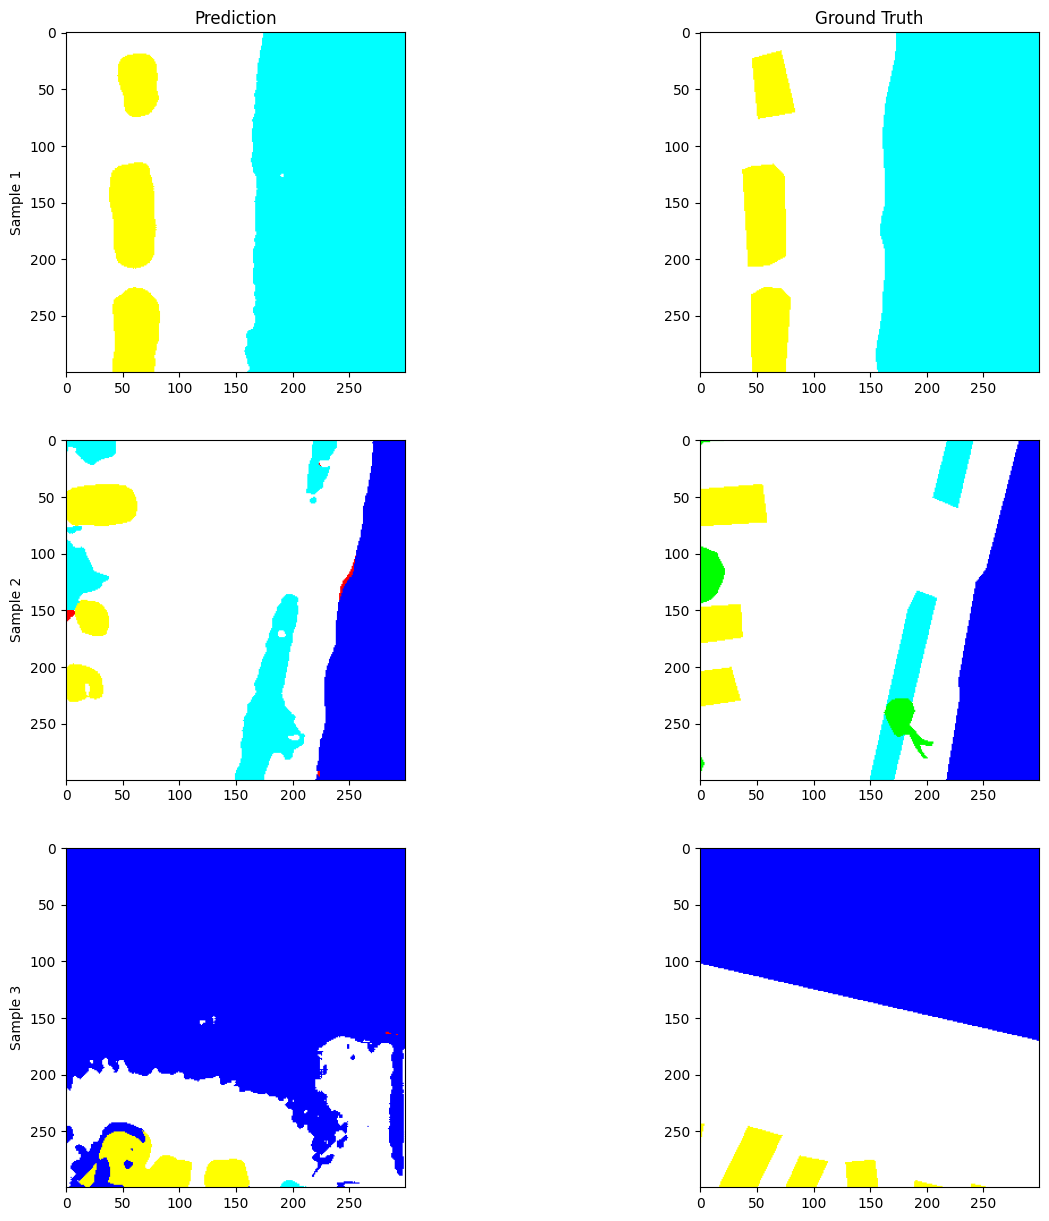

In [213]:
fig = plt.figure(figsize=(15, 15))
rows = 3
columns = 2
sub_plot_1 =fig.add_subplot(rows, columns, 1)
plt.imshow(output[0])
sub_plot_1.set_title("Prediction")
sub_plot_1.set_ylabel("Sample 1")
sub_plot_2 = fig.add_subplot(rows, columns, 2)
sub_plot_2.set_title("Ground Truth")
plt.imshow(gt[0])
sub_plot_3 = fig.add_subplot(rows, columns, 3)
plt.imshow(output[1])
sub_plot_3.set_ylabel("Sample 2")
sub_plot_4 = fig.add_subplot(rows, columns, 4)
plt.imshow(gt[1])
sub_plot_5 = fig.add_subplot(rows, columns, 5)
plt.imshow(output[2])
sub_plot_5.set_ylabel("Sample 3")
sub_plot_6= fig.add_subplot(rows, columns, 6)
plt.imshow(gt[2])
plt.show()